In [1]:
import numpy as np
import matplotlib.pyplot as plt

import jax as jx
import jax.numpy as jnp
from jax.example_libraries import optimizers
from functools import partial

from tqdm import tqdm

key = jx.random.PRNGKey(0)

In [2]:
def init_params(layers, key):
  # Glorot initialization
  Ws = []
  bs = []
  for i in range(len(layers) - 1):
    std_glorot = jnp.sqrt(2/(layers[i] + layers[i + 1]))
    key, subkey = jx.random.split(key)
    Ws.append(jx.random.normal(subkey, (layers[i], layers[i + 1]))*std_glorot)
    bs.append(jnp.zeros(layers[i + 1]))
  return [Ws, bs]

@jx.jit
def forward_pass(H, params):
  # Forward pass with tanh
  Ws = params[0]
  bs = params[1]
  N_layers = len(Ws)
  for i in range(N_layers - 1):
    H = jnp.matmul(H, Ws[i]) + bs[i]
    H = jnp.tanh(H)
  Y = jnp.matmul(H, Ws[-1]) + bs[-1]
  return Y

def create_grads():
  fp_wrapper = lambda x, params: forward_pass(x, params)[0]
  du_dx = jx.grad(fp_wrapper)
  du_dx_wrapper = lambda x, params: du_dx(x, params)[0]
  dU_dx = jx.vmap(du_dx,in_axes=(0,None), out_axes=0)
  dU_dxx = jx.vmap(jx.grad(du_dx_wrapper),in_axes=(0,None), out_axes=0)
  return dU_dx, dU_dxx

grad_X, grad_XX = create_grads()

@partial(jx.jit, static_argnums=(0,))
def step(loss, i, opt_state, X_batch, Y_batch):
    # Optimizer step
    params = get_params(opt_state)
    g = jx.grad(loss)(params, X_batch, Y_batch)
    return opt_update(i, g, opt_state)

def train(loss, X, Y, X_c, opt_state, X_bd = None, X_bn = None, nIter = 10000, stop=1e-5):
    train_loss = []
    val_loss = []
    key = jx.random.PRNGKey(0)
    for it in (pbar := tqdm(range(nIter))):
        opt_state = step(loss, it, opt_state, X, Y)
        if it % 50 == 0:
            params = get_params(opt_state)
            train_loss_value = loss(params, X, Y)
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it, train_loss_value)
            pbar.set_description(f"{to_print}")
            if train_loss_value<stop:break
    return get_params(opt_state), train_loss, val_loss

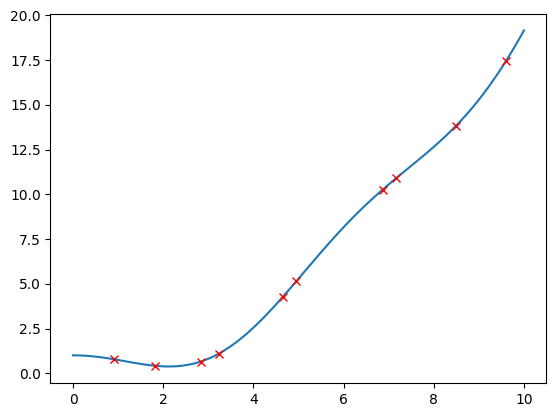

In [14]:
X = np.linspace(0, 10, 100)[:, None]
Y = 0.2*X**2 + np.cos(X)

rng_agent = np.random.default_rng(6516)
train_samples = rng_agent.choice(X.shape[0], 10)
X_train = X[train_samples]
Y_train = Y[train_samples]

plt.plot(X, Y)
plt.plot(X_train, Y_train, "rx")
plt.show()

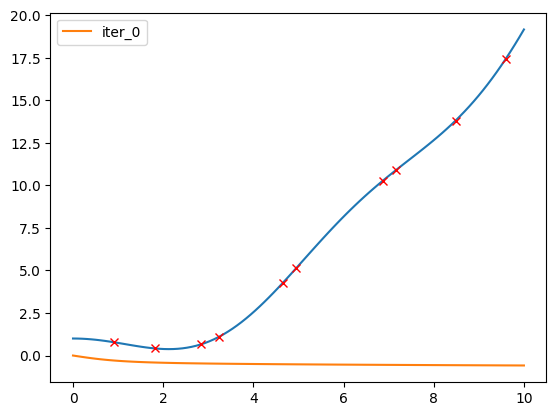

it 9950, train loss = 3.558847e-05: 100%|███████████████████████████████████████| 10000/10000 [00:08<00:00, 1235.68it/s]


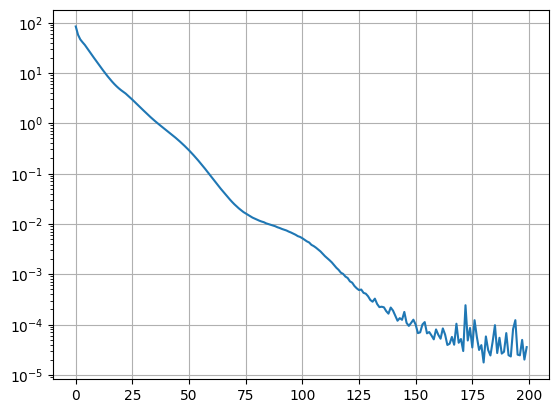

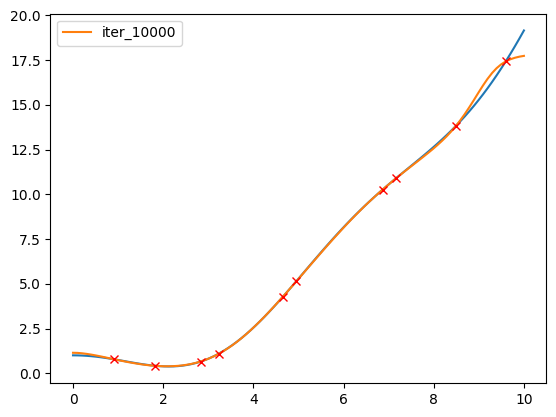

In [25]:
layers = [1] + [10]*3 + [1]
nIter = 10000
lr = 1e-3


key = jx.random.PRNGKey(0)
params = init_params(layers, key)

opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(params)


plt.plot(X, Y)
plt.plot(X, forward_pass(X, params), label="iter_0")
plt.plot(X_train, Y_train, "rx")
plt.legend()
plt.show()

@jx.jit
def loss(params, X, Y):
    Y_pred = forward_pass(X, params)
    MSE = jnp.mean((Y_pred-Y)**2)
    return  MSE


params, train_loss, val_loss = train(loss, X_train, Y_train, None, opt_state, nIter = nIter)
opt_state = opt_init(params)

plt.semilogy()
plt.plot(train_loss)
plt.grid()
plt.show()

plt.plot(X, Y)
plt.plot(X, forward_pass(X, params), label=f"iter_{nIter}")
plt.plot(X_train, Y_train, "rx")
plt.legend()
plt.show()